In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import chess
import chess.pgn

from torch.utils.data import Dataset, DataLoader, IterableDataset

from time import time
import tqdm

HEADERS = ("result", "whiteElo", "blackElo", "timeControl", "sideToPlay", "bitmaps", "movePlayed")
TRAINING_SET_SIZE = 2867018
BATCH_SIZE = 64

In [2]:
def extract_fens_from_pgn(pgn_file, label_from="result"):
    positions = []
    with open(pgn_file, "r", encoding="utf-8") as f:
        while True:
            game = chess.pgn.read_game(f)
            if game is None:
                break

            board = game.board()
            result = game.headers.get("Result")

            # Label based on game outcome
            if result == "1-0":
                label = 1.0
            elif result == "0-1":
                label = -1.0
            else:
                label = 0.0

            # Step through moves
            for move in game.mainline_moves():
                board.push(move)
                fen = board.fen()
                positions.append((fen, label))  # ← You can also call Stockfish here if you want

    return positions


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class PositionEvaluatorNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(13, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        return torch.tanh(self.fc2(x))  # Output between -1 and 1
    

class ChessBotNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # 13 channels: 12 pieces + side to play (tensor[true's|false's])
        self.conv1 = nn.Conv2d(13,64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 8 * 128, 256)
        self.fc2 = nn.Linear(256, 64)
        self.relu = nn.ReLU()

        # Initialize weights
        nn.init.kaiming_uniform_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.conv2.weight, nonlinearity='relu')
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)


    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)  # Output raw logits
        return x


## OUTPUT COMPLETE MOVES
class CompleteChessBotNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # 13 channels: 12 pieces + side to play (tensor[true's|false's])
        self.conv1 = nn.Conv2d(13,64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 8 * 128, 256)
        self.fc2 = nn.Linear(256, 64 * 63) # (Choose 2 squares from the board where the order matters) 
        self.relu = nn.ReLU()

        # Initialize weights
        nn.init.kaiming_uniform_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.conv2.weight, nonlinearity='relu')
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)


    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)  # Output raw logits
        return x
## Idea:
##   One model that answers "best piece to move in this position"
##   Then another model that answers "best square to move piece X to"

# Add normalization after conv
# Switch from relu to sigmoid or smth
# Add more preprocessing by making the tensors there and avoid pre processing before training

In [4]:
from itertools import product


piece_to_idx = {
    'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
    'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
}

def board_to_tensor(board):
    tensor = np.zeros((12, 8, 8), dtype=np.uint8)
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            idx = piece_to_idx[piece.symbol()]
            row = 7 - square // 8
            col = square % 8
            tensor[idx, row, col] = 1
    return tensor

def idxToUci(idx):
    return chr(ord('a') + idx % 8) + str(idx // 8 + 1)


letters = ["a", "b", "c", "d", "e", "f", "g", "h"]
numbers = list(range(1, 10)) # [1..9]
MOVE_DICTIONARY = {}
cumulative = 0
for i in range(8):
    for j in range(8):
        for k in range(8):
            for w in range (8):
                if (i == k and j == w):
                    cumulative += 1
                    continue
                from_square = f"{letters[i]}{numbers[j]}"
                to_square = f"{letters[k]}{numbers[w]}"
                MOVE_DICTIONARY[f"{from_square}{to_square}"] = (i * 8**3) + (j * 8**2) + (k * 8) + w - cumulative
REVERSE_MOVE_DICTIONARY = {
    value: key for key,value in MOVE_DICTIONARY.items()
}

In [5]:
import ast
import csv
from io import StringIO
import json
import random
from typing import Literal
import pandas as pd
import polars as pl

class ChessEvalDataset(Dataset):
# class ChessEvalDataset(IterableDataset):
    def __init__(self, file: str, model: Literal["pieces", "moves"] = "pieces", load_batch_size = 6_400):
        self.model = model
        self.lazy_dataset = pl.scan_csv(file, has_header=False, new_columns=HEADERS)
        self.batch_size = load_batch_size
        self.feature_cols = ["bitmaps", "sideToPlay"]
        self.target_col = "movePlayed"
        self.cached_batches = {}
        self.batches_ids: list[int] = list()
        self.total_rows = self.lazy_dataset.select(pl.len()).collect().item()

    def __len__(self):
        return self.total_rows
    
    def __uciMoveToSquare(self, move: str):
        return  (int(move[1]) - 1) * 8 + (ord(move[0]) - ord('a'))

    def __getitem__(self, idx):
        # Calculate which batch this index belongs to
            batch_idx = idx // self.batch_size
            
            # Check if this batch is already cached
            if batch_idx not in self.cached_batches:
                # Calculate batch range
                start_idx = batch_idx * self.batch_size
                end_idx = min((batch_idx + 1) * self.batch_size, self.total_rows)
                
                # Fetch only this batch of data using offset and limit
                batch_dataset = (self.lazy_dataset
                            .slice(start_idx, end_idx - start_idx)
                            .collect())
                
                # Process features and target
                features = batch_dataset.select(self.feature_cols)
                bitmaps = np.empty(shape=(end_idx-start_idx, 12, 8, 8))

                bitmaps_list = [json.loads(bmp) for bmp in features["bitmaps"]]
                bitmaps = np.array(bitmaps_list, dtype=np.float32)


                side_channels = np.array([
                    np.ones((1, 8, 8)) if side == "True" else np.zeros((1, 8, 8))
                    for side in features["sideToPlay"]
                ], dtype=np.float32)
    
                bitmaps = np.concatenate((bitmaps, side_channels), axis = 1)
                features = torch.tensor(bitmaps, dtype=torch.float32)
                
                targets = batch_dataset.select(self.target_col).map_rows(lambda move_string: MOVE_DICTIONARY[move_string[0][:4]]).to_numpy()
                # target_values = np.empty(shape=(end_idx-start_idx))
                # for idx, move in enumerate(targets):
                #     move = move[0]
                #     if self.model == "pieces":
                #         label = move[:2]
                #     else:
                #         label = move[2:]
                #     target_values[idx] = self.__uciMoveToSquare(label)
                    
                targets = torch.tensor(targets, dtype=torch.long)
                
                # Cache this batch
                self.cached_batches[batch_idx] = (features, targets)
                
                if len(self.cached_batches) > 1:  # Keep only 1 batches in memory, delete oldest
                    self.cached_batches.pop(self.batches_ids[0])
                    self.batches_ids.pop(0)
                self.batches_ids.append(batch_idx)

            
            # Get the item from the cached batch
            features, targets = self.cached_batches[batch_idx]
            idx_in_batch = idx % self.batch_size
            
            return features[idx_in_batch], targets[idx_in_batch]

    # def parse_line(self, line: str):
    #     parts = next(
    #         csv.DictReader(StringIO(line), quoting=csv.QUOTE_MINIMAL, fieldnames=HEADERS)
    #     )
        
    #     entry = {
    #         "bitmaps": ast.literal_eval(parts["bitmaps"]),
    #         "sideToPlay": parts["sideToPlay"] == "True",
    #         "movePlayed": parts["movePlayed"]
    #     }

    #     bitmaps = np.array(entry["bitmaps"])
    #     side_channel = np.ones((1, 8, 8)) if entry["sideToPlay"] else np.zeros((1, 8, 8))

    #     bitmaps = np.concatenate((bitmaps, side_channel))
    #     X = torch.tensor(bitmaps, dtype=torch.float32)

    #     move = entry["movePlayed"]
    #     if self.model == "pieces":
    #         label = move[:2]
    #     else:
    #         label = move[2:]
    #     y = torch.tensor(self.__uciMoveToSquare(label)).long()
    #     print(X)
    #     print(y)
    #     return X, y
    
    # def __iter__(self):
    #     READ_SIZE = 16_384 # 4.5GiB in GPU
    #     with open(self.file, "r") as f:
    #         for idx in range(TRAINING_SET_SIZE):
    #             lines = f.readlines(READ_SIZE)
    #             X_batch = torch.empty(READ_SIZE, 13, 8, 8)
    #             y_batch = torch.empty(READ_SIZE, 64, 1)
    #             for idx, line in enumerate(lines):
    #                 # self.open_file.seek(self.offsets[idx]) # Go to line idx
    #                 # yield self.parse_line(self.open_file.readline())
    #                 X, y = self.parse_line(line)
    #                 X_batch[idx] = X
    #                 y_batch[idx] = y
    #             yield X_batch, y_batch

In [6]:
DATASET_PATH = '../dataset/processed/results_skip_initial.csv'
NUM_EPOCHS = 100

TRAINING_MODE = "pieces" # "pieces" or "moves"
MODEL_WEIGHTS_OUTPUT_PATH = "CompleteModel_SKIP_INITIAL.pth"
test = ChessEvalDataset(file = DATASET_PATH, model=TRAINING_MODE, load_batch_size = 300_000)
loader = DataLoader(test, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CompleteChessBotNetwork().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

print(torch.cuda.is_available())
print("Using device: ", device)
for epoch in range(NUM_EPOCHS):
    break
    model.train()
    t0 = time()
    running_loss = 0.0
    for board_tensor_batch, target_eval_batch in tqdm.tqdm(loader):
        board_tensor_batch, target_eval_batch = board_tensor_batch.to(device), target_eval_batch.to(device)  # Move data to GPU
        optimizer.zero_grad()

        pred = model(board_tensor_batch)

        # Compute loss
        loss = loss_fn(pred, target_eval_batch.squeeze(1))
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_loss += loss.item()
    tf = time()
    print(f"Epoch {epoch}, Loss: {loss.item():.4f} - {running_loss / len(loader):.4f} | Time: {tf-t0}")

    if epoch % 5 == 0:
        torch.save(model.state_dict(), f"CompleteModel_SKIP_INITIAL_epoch_{epoch+1}.pth")       
# Save the trained model
# torch.save(model.state_dict(), MODEL_WEIGHTS_OUTPUT_PATH)

True
Using device:  cuda


In [7]:
import csv
from io import StringIO
import pandas as pd
import numpy as np
import ast
# torch.save(model.state_dict(), "pieces_model_skip_initial_full_dataset.pth")
test = pd.read_csv(
    '../dataset/processed/results_skip_initial.csv', 
    nrows = 20, 
    names = HEADERS,
)
entry = test.iloc[0]
bitmaps = np.array(ast.literal_eval(entry["bitmaps"]))
side_channel = np.ones((1, 8, 8)) if entry["sideToPlay"] == "True" else np.zeros((1, 8, 8))

bitmaps = np.concatenate((bitmaps, side_channel), axis=0)
X = bitmaps
played_move = entry["movePlayed"]

In [8]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model = CompleteChessBotNetwork().to(device)
trained_model.load_state_dict(torch.load("./CompleteModel_SKIP_INITIAL_epoch_76.pth"))
trained_model.eval()  # Set model to evaluation mode

def predict_move(bitmaps):
    bitmaps  = np.expand_dims(bitmaps, axis=0)
    X_tensor = torch.tensor(bitmaps, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        logits = trained_model(X_tensor)
    
    logits = logits.squeeze(0)  # Remove batch dimension
    
    probabilities = torch.softmax(logits, dim=0).cpu().numpy()  # Convert to probabilities
    
    return probabilities

In [9]:
# import matplotlib.pyplot as plt
# import chess

# def plot_board(bitmaps, move_probs=None):
#     board = np.zeros((8,8,3))
#     colors = [(240/255, 217/255, 181/255), (181/255, 136/255, 99/255)]

#     fig, ax = plt.subplots(figsize=(8, 8))
#     for i in range(8):
#         for j in range(8):
#             color = colors[(i + j) % 2]
#             rect = plt.Rectangle((j, 7-i), 1, 1, facecolor=color)
#             ax.add_patch(rect)
#             piece_symbols = ['P', 'N', 'B', 'R', 'Q', 'K', 'p', 'n', 'b', 'r', 'q', 'k']

#     for idx, symbol in enumerate(piece_symbols):
#         channel = bitmaps[idx]
#         for i in range(8):
#             for j in range(8):
#                 if channel[i, j] == 1:
#                     ax.text(j + 0.5, 7-i + 0.5, symbol, fontsize=24, ha='center', va='center')

#     if move_probs is not None:
#         for i in range(8):
#             for j in range(8):
#                 prob = move_probs[i, j]
#                 if prob > 0.05: 
#                     ax.text(j + 0.5, 7-i + 0.8, f"{prob:.2f}", fontsize=8, color="red", ha='center')

#     ax.set_xlim(0, 8)
#     ax.set_ylim(0, 8)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     plt.show()


########## WORKING CODDE:
import matplotlib.pyplot as plt
import numpy as np

# Mapping of piece letters to unicode chess symbols
PIECE_UNICODE = {
    'P': '♙', 'N': '♘', 'B': '♗', 'R': '♖', 'Q': '♕', 'K': '♔',
    'p': '♟︎', 'n': '♞', 'b': '♝', 'r': '♜', 'q': '♛', 'k': '♚'
}

def plot_board(bitmaps, move_probs=None):
    board = np.zeros((8, 8, 3))
    colors = [(240/255, 217/255, 181/255), (181/255, 136/255, 99/255)]

    fig, ax = plt.subplots(figsize=(8, 8))

    # Draw squares
    for i in range(8):
        for j in range(8):
            color = colors[(i + j) % 2]
            rect = plt.Rectangle((j, 7-i), 1, 1, facecolor=color)
            ax.add_patch(rect)

    # Draw pieces
    piece_symbols = [ 'P', 'N', 'B', 'R', 'Q', 'K', 'p', 'n', 'b', 'r', 'q', 'k']
    for idx, symbol in enumerate(piece_symbols):
        channel = bitmaps[idx]
        for i in range(8):
            for j in range(8):
                if channel[i, j] == 1:
                    piece_unicode = PIECE_UNICODE[symbol]
                    ax.text(j + 0.5, 7 - i + 0.5, piece_unicode, fontsize=48, ha='center', va='center')

    # Draw move probabilities
    if move_probs is not None:
        for i in range(8):
            for j in range(8):
                prob = move_probs[i, j]
                if prob > 0:  # Show only significant probs
                    ax.text(j + 0.5, 7 - i + 0.1, f"{prob:.2f}", fontsize=8, color="red", ha='center')
                    # ax.text(j + 0.5, i + 0.8, f"{i*8 + j}", fontsize=8, color="red", ha='center')

    # Add a-h and 1-8 labels
    # files = ['h', 'g', 'f', 'e', 'd', 'c', 'b', 'a']
    files = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    ranks = ['8', '7', '6', '5', '4', '3', '2', '1']
    for i in range(8):
        # Bottom labels
        ax.text(i + 0.5, -0.3, files[i], ha='center', va='center', fontsize=14)
        # Left side labels
        ax.text(-0.3, i + 0.5, ranks[7-i], ha='center', va='center', fontsize=14)

    ax.set_xlim(0, 8)
    ax.set_ylim(0, 8)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


[2.8354762e-12 2.3803321e-22 8.3137543e-22 ... 8.7194191e-23 4.8136623e-25
 1.4040617e-08]
[('e5e4', np.float32(0.5145766)), ('c7c6', np.float32(0.22040166)), ('c4d5', np.float32(0.09713562)), ('d7c6', np.float32(0.06741336)), ('f5e4', np.float32(0.040766478)), ('e6d5', np.float32(0.012268832)), ('b7c6', np.float32(0.009238841)), ('a7a6', np.float32(0.007040132)), ('e8d8', np.float32(0.0039958903)), ('e2e3', np.float32(0.003422276))]


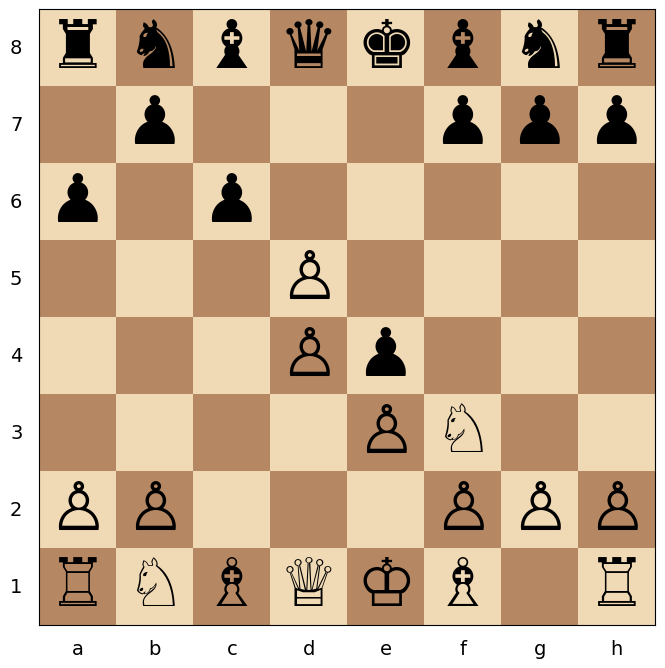

In [10]:
probabilities = predict_move(bitmaps)  # model output
print(probabilities)

# Recebmos as classes dos moves: converter para moves e depois ordernar os moves por probabilidade
moves = [REVERSE_MOVE_DICTIONARY[idx] for idx, prob in enumerate(probabilities)]
best_moves = sorted(
    zip(moves, probabilities),
    key=lambda x: x[1], # Sort by probability
    reverse=True
)
print(best_moves[:10])
plot_board(bitmaps)

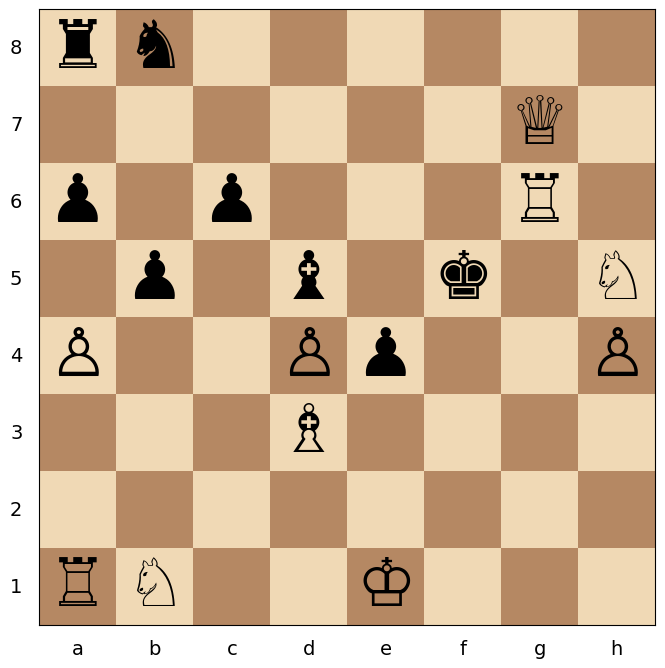

In [ ]:
from IPython.display import clear_output, display
import time

board = chess.Board()
probs = np.zeros((8, 8))
input_tensor = board_to_tensor(board)
plot_board(input_tensor)

while not board.is_game_over():


    user_move = input("Your move (e.g., e2e4): ")
    if user_move == "exit":
        break
    try:
        board.push_san(user_move)
    except Exception as e:
        print("Invalid move. Try again.")
        continue
    clear_output(wait=True)

    # Convert board to bitmap
    bitmaps = board_to_tensor(board)
    side_channel = np.ones((1, 8, 8)) if board.turn == chess.WHITE else np.zeros((1, 8, 8))
    input_tensor = np.concatenate((bitmaps, side_channel), axis=0)

    # Model predicts best move
    probs = predict_move(input_tensor)
    best_square_idx = np.argmax(probs, keepdims=True)
    # Recebmos as classes dos moves: converter para moves e depois ordernar os moves por probabilidade
    moves = [REVERSE_MOVE_DICTIONARY[idx] for idx, prob in enumerate(probabilities)]
    best_moves = sorted(
        zip(moves, probabilities),
        key=lambda x: x[1], # Sort by probability
        reverse=True
    )

    for move in best_moves:
        try:
            board.push_uci(move[0])
            break
        except:
            continue

    # Convert board to bitmap
    bitmaps = board_to_tensor(board)
    side_channel = np.ones((1, 8, 8)) if board.turn == chess.WHITE else np.zeros((1, 8, 8))
    input_tensor = np.concatenate((bitmaps, side_channel), axis=0)
    plot_board(input_tensor)